<a href="https://colab.research.google.com/github/ClaudioAresu/TensorFlow/blob/main/05transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Feb 28 11:03:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper function, now we could rewrite them all, however, this is tedious

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-28 11:03:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-28 11:03:02 (78.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note;** If you're running this notebook in Google Colab, when it times out Cola wiill delete the file, so you'll have to redownload it if you want to access the helper functions

## Let's get some data

we will use the pretrained models with 'tf.keras.applications' 

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-02-28 11:03:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  32.9MB/s    in 5.4s    

2023-02-28 11:03:13 (29.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [7]:
#Create a training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
from keras.losses import categorical_crossentropy
import tensorflow as tf
IMG_SIZE = (224, 224)
BACTH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.62857132e+01 1.32857151e+01 4.28571415e+00]
   [1.52142859e+01 1.22142859e+01 3.21428585e+00]
   [1.42857141e+01 1.12857141e+01 3.85714269e+00]
   ...
   [3.70663338e+01 2.80663319e+01 2.10663319e+01]
   [3.54489403e+01 2.64489403e+01 1.94489403e+01]
   [3.38163261e+01 2.48163280e+01 1.78163280e+01]]

  [[1.40714283e+01 1.40714283e+01 4.07142830e+00]
   [1.50000000e+01 1.50000000e+01 7.00000000e+00]
   [1.50000000e+01 1.50000000e+01 7.00000000e+00]
   ...
   [3.71734695e+01 2.81734695e+01 2.11734695e+01]
   [3.62244682e+01 2.72244701e+01 2.02244701e+01]
   [3.71479530e+01 2.81479511e+01 2.11479511e+01]]

  [[1.33571424e+01 1.47857141e+01 7.00000000e+00]
   [1.23265305e+01 1.37551022e+01 5.96938753e+00]
   [1.19285707e+01 1.33571424e+01 6.80612183e+00]
   ...
   [3.39285431e+01 2.49285450e+01 1.83571167e+01]
   [2.71274681e+01 1.81274681e+01 1.15560389e+01]
   [2.57806072e+01 1.67806072e+01 1.02091789e+01]]

  ...

  [[6.08673744e+01 4.32959023e+01 2.90816383e+01]
   [5

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functionalò API gives uis more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [12]:
from os.path import dirname
# Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze layers in the bse model ( so the underlying pre-trained weights/patterns aren't updated)
base_model.trainable = False

# Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2 you will need to normalize the inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}.")

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")
                                  ])

16705208/16705208 [==============================] - 1s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280).
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230228-110327
Epoch 1/5
24/24 [==============================] - 21s 262ms/step - loss: 1.8697 - accuracy: 0.4147 - val_loss: 1.2752 - val_accuracy: 0.7451
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.0921 - accuracy: 0.7773 - val_loss: 0.8696 - val_accuracy: 0.8289
Epoch 3/5
24/24 [==============================] - 5s 179ms/step - loss: 0.7843 - accuracy: 0.8227 - val_loss: 0.6825 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6377 - accuracy: 0.8547 - val_loss: 0.5931 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 177ms/step - loss: 0.5462 - accuracy: 0.8800 - val_loss: 0.5440 - val_accuracy: 0.8618


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 102ms/step - loss: 0.5552 - accuracy: 0.8636


[0.5552136898040771, 0.8636000156402588]

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


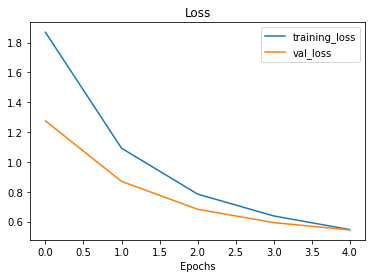

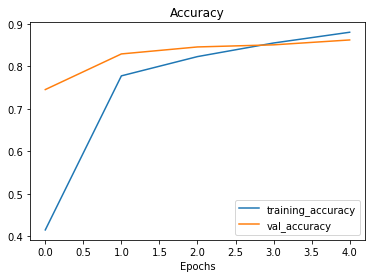

In [17]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have created a tensor after our model of shape (None, 7, 7, 1280)

But then when it passes through Global AveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and them pas it to GlobalAveragePooling2D.

In [18]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor trhoufh a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Random averaged input tensor:\n {global_average_pooled_tensor}\n")

# Pass the random tensor trhoufh a global average pooling 2d layer
global_maximum_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Random maximum input tensor:\n {global_maximum_pooled_tensor}\n")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Random averaged input tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Random maximum input tensor:
 [[0.9058464 1.1603122 1.6994323]]



In [19]:
# Replicate the Global Average Pool 2D layer
tf.reduce_mean(input_tensor, axis=[1,2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
# Repplicate the Global Max Pool 2D layer
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [21]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-02-28 11:04:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.5MB/s    in 5.8s    

2023-02-28 11:04:24 (22.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
walk_through_dir(dir_path="10_food_classes_1_percent/")

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings

In [91]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [25]:
from keras.engine.base_layer import TensorFlowOpLayer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) #keep for models like ResNet50V2
], name="data_augmentation")

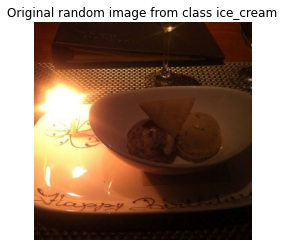

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir= "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original random image from class {target_class}");


In [95]:
img.shape

(512, 512, 3)

(-0.5, 504.5, 532.5, -0.5)

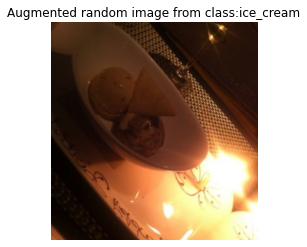

In [100]:
augmented_img=data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class:{target_class}")
plt.axis(False)

In [101]:
augmented_img.shape

TensorShape([533, 505, 3])

In [28]:
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
#Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create inpout layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

#Put a de nse layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

#Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

#Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=int(0.25 * len(test_data_1_percent)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230228-110430
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4023 - accuracy: 0.0857

3/3 [==============================] - 15s 3s/step - loss: 2.4023 - accuracy: 0.0857 - val_loss: 2.2335 - val_accuracy: 0.1612
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1395 - accuracy: 0.2286 - val_loss: 2.0824 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9124 - accuracy: 0.3571 - val_loss: 1.9545 - val_accuracy: 0.3947
Epoch 4/5
3/3 [==============================] - 8s 3s/step - loss: 1.8016 - accuracy: 0.5000 - val_loss: 1.8484 - val_accuracy: 0.4688
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6042 - accuracy: 0.5714 - val_loss: 1.7684 - val_accuracy: 0.5164


In [29]:
results_1_percent = model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 6s 70ms/step - loss: 1.7732 - accuracy: 0.4908


In [30]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

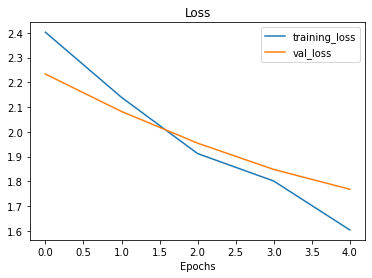

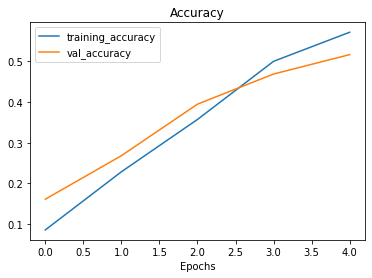

In [31]:
plot_loss_curves(history=history_1_percent)

In [32]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [33]:
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_2 = keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230228-110526
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9992 - accuracy: 0.3320


Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 682ms/step - loss: 1.9992 - accuracy: 0.3320 - val_loss: 1.4302 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.6827
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 661ms/step - loss: 1.3255 - accuracy: 0.6827 - val_loss: 1.0210 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.7440
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 545ms/step - loss: 1.0145 - accuracy: 0.7440 - val_loss: 0.7902 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8706 - accuracy: 0.7840
Epoch 4: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [34]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [35]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6374 - accuracy: 0.8392


In [36]:
results_10_percent_data_aug

[0.637446939945221, 0.8392000198364258]

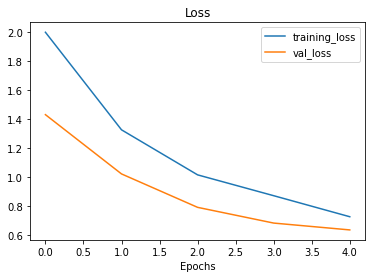

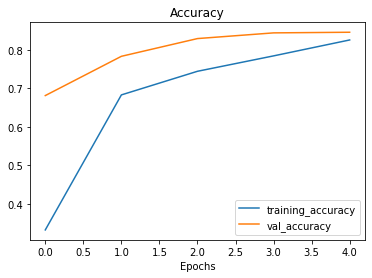

In [37]:
plot_loss_curves(history_model_2)

### Loading in checkpointed weights

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6374 - accuracy: 0.8392


In [40]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [41]:
results_10_percent_data_aug, loaded_weights_model_results

([0.637446939945221, 0.8392000198364258],
 [0.6374468207359314, 0.8392000198364258])

In [42]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

 ## Fine-tuning an existing model

In [43]:
model_2.layers

In [46]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fafdfadb070> True
<keras.engine.sequential.Sequential object at 0x7fafed6fbc10> True
<keras.engine.functional.Functional object at 0x7fafe07ec190> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fafdfb36e20> True
<keras.layers.core.dense.Dense object at 0x7fafebb0fc70> True


In [52]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [55]:
#How many trainable variables

print(len(model_2.layers[2].trainable_variables))

0


In [56]:
#unfreezing last ten hidden layers for fine tuning

base_model.trainable = True


for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001), #When fine-tuning is good to change the lr for at least about 10x 
                metrics=["accuracy"])

In [57]:
#Checking the model to see if the mentioned layers have been unfrozen

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

**Note:** a good paper for fine-tuning is Universal Language Model FIne-Tuning for Text Classification by Jeremy Howard and Sebastian Ruder

In [60]:
print(len(model_2.trainable_variables))

12


In [70]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_model_2.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")]
                                               )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230228-113548
Epoch 5/10
24/24 [==============================] - 12s 447ms/step - loss: 0.4207 - accuracy: 0.8760 - val_loss: 0.4188 - val_accuracy: 0.8635
Epoch 6/10
24/24 [==============================] - 13s 529ms/step - loss: 0.3955 - accuracy: 0.8907 - val_loss: 0.4053 - val_accuracy: 0.8668
Epoch 7/10
24/24 [==============================] - 12s 466ms/step - loss: 0.3343 - accuracy: 0.9133 - val_loss: 0.4225 - val_accuracy: 0.8635
Epoch 8/10
24/24 [==============================] - 11s 437ms/step - loss: 0.3086 - accuracy: 0.9147 - val_loss: 0.4163 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 11s 429ms/step - loss: 0.2747 - accuracy: 0.9200 - val_loss: 0.4262 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 14s 560ms/step - loss: 0.2204 - accuracy: 0.9467 - val_loss: 0.4638 - val_accuracy: 0.8421


In [71]:
#Evaluate the fined-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.4232 - accuracy: 0.8588


In [72]:
results_10_percent_data_aug

[0.637446939945221, 0.8392000198364258]

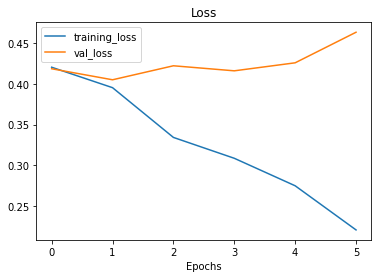

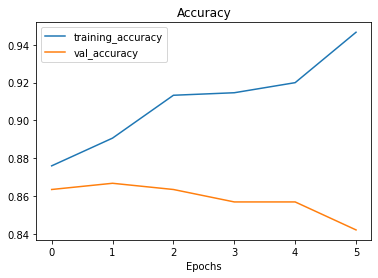

In [73]:
#Check the loss curves of our fine-tuned model
plot_loss_curves(history=history_fine_10_percent_data_aug)

In [81]:
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects.
  """
  #Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

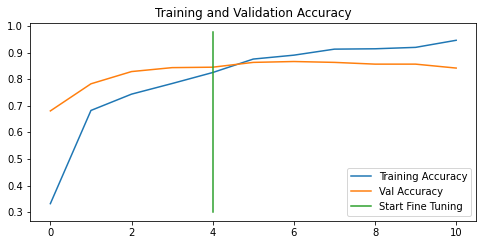

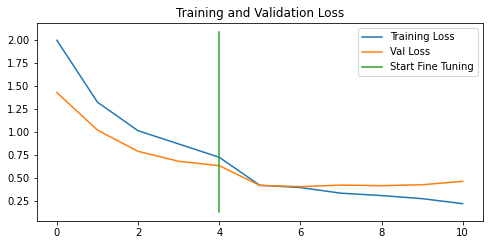

In [82]:
compare_histories(history_model_2, history_fine_10_percent_data_aug, initial_epochs=5)

In [ ]:
## Fine-tune an existing model utilizing all of the data

In [83]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-02-28 11:55:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  41.5MB/s    in 13s     

2023-02-28 11:55:43 (39.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [86]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [87]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 

In [88]:
#Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [89]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4232 - accuracy: 0.8588


[0.4232349097728729, 0.8587999939918518]

to traina  fine-tuning model(model_4) we need to revert model_2 to its feature extraction weights

In [90]:
#Load weights from its checkpoints, that way we can fine-tune from the same stage the 10% data model was fine-tuned from
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [93]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6374 - accuracy: 0.8392


[0.637446939945221, 0.8392000198364258]

In [102]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d_2 True
4 dense True


In [104]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [107]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])


In [109]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_fine_10_percent_data_aug.epoch[-6],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230228-124245


Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.8211

235/235 [==============================] - 87s 366ms/step - loss: 0.5614 - accuracy: 0.8211 - val_loss: 0.3485 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - 83s 353ms/step - loss: 0.4858 - accuracy: 0.8439 - val_loss: 0.3217 - val_accuracy: 0.8882
Epoch 7/10
235/235 [==============================] - 78s 331ms/step - loss: 0.4427 - accuracy: 0.8588 - val_loss: 0.2948 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 73s 309ms/step - loss: 0.4032 - accuracy: 0.8733 - val_loss: 0.3294 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 72s 305ms/step - loss: 0.3688 - accuracy: 0.8825 - val_loss: 0.2691 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 69s 292ms/step - loss: 0.3408 - accuracy: 0.8911 - val_loss: 0.3062 - val_accuracy: 0.8931


In [111]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 77ms/step - loss: 0.2554 - accuracy: 0.9192


[0.25538602471351624, 0.9192000031471252]

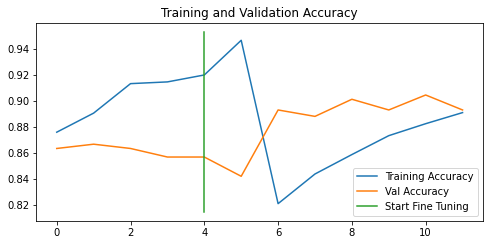

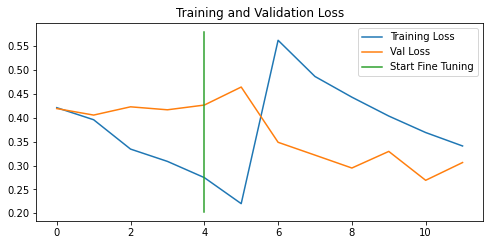

In [113]:
compare_histories(original_history=history_fine_10_percent_data_aug, new_history=history_fine_10_classes_full, initial_epochs=5)

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiments with 10 Food101 Classes" \
 --description "A series of different transfer learning experiments with varying amount of experiments" \
 --one_shot #Exit the uploaded once it finished uploading

In [ ]:
!tensorboard dev list

In [ ]:
#To delete an experimente, use the code below and the ID of the experiment
!tensorboard dev delete --experiment_id 